In [1]:
from matplotlib import pyplot as plt
from itertools import product
import seaborn as sns
import numpy as np
import pandas as pd
import pingouin as pg
import os.path as op
import argparse
import re
import pickle
from statsmodels.stats.anova import AnovaRM
from scipy import signal, stats
import pymc as pm
import arviz as az
from sklearn.preprocessing import LabelEncoder, StandardScaler
# EEG utilities
import mne
from pycrostates.cluster import ModKMeans
from pycrostates.io import read_cluster, ChData
# BIDS utilities
from util.io.bids import DataSink
from bids import BIDSLayout

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Read FFR peaks by microstate
power_f0 = pd.read_csv('microstates-power_f0.csv') # already has excluded subjects dropped, whoops, re-run this block of code to preserve them

# Read accuracies
accuracy = pd.read_csv('accuracy.csv')

In [3]:
power_f0

,subject,target,stim,microstate,frequency,power,trials
0,3,130,130,A,129.460581,-0.366394,84
1,3,200,130,A,129.460581,5.104164,111
2,3,280,130,A,129.460581,2.302977,96
3,3,130,130,B,129.460581,1.635729,95
4,3,200,130,B,129.460581,1.120924,142
...,...,...,...,...,...,...,...
1840,45,200,280,D,278.838174,0.194377,96
1841,45,280,280,D,278.838174,2.346454,125
1842,45,130,280,E,278.838174,-3.038763,96
1843,45,200,280,E,278.838174,-1.076164,82


In [4]:
# Add accuracy group to dataframe
power_f0 = power_f0.merge(accuracy, left_on = ["subject"], right_on = ["subject"])
np.unique(power_f0.subject)

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 44, 45])

In [75]:
# power_f0 = power_f0[power_f0.subject < 33]
# np.unique(power_f0.subject)

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [5]:
# Sanity check with other notebook
aov = AnovaRM(
    data = power_f0, 
    depvar = 'power',
    subject = 'subject', 
    within = ['microstate', 'target', 'stim']
)
res = aov.fit()
print(res)

                        Anova
                       F Value  Num DF  Den DF  Pr > F
------------------------------------------------------
microstate              0.7515  4.0000 160.0000 0.5584
target                  2.6684  2.0000  80.0000 0.0755
stim                    8.4137  2.0000  80.0000 0.0005
microstate:target       1.1368  8.0000 320.0000 0.3380
microstate:stim         1.1225  8.0000 320.0000 0.3475
target:stim             0.8336  4.0000 160.0000 0.5057
microstate:target:stim  0.7894 16.0000 640.0000 0.6986



#### More regular ANOVAs

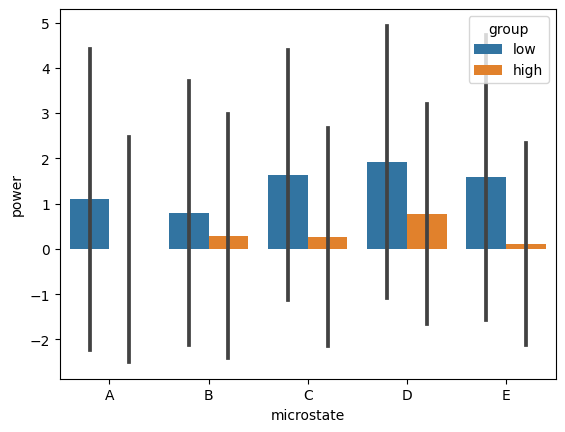


ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc    np2      eps
-----------  ------  -----  -----  ------  -----  -------  -----  -------
group        64.360      1     39  64.360  6.027    0.019  0.134  nan
microstate   17.892      4    156   4.473  2.517    0.044  0.061    0.881
Interaction   5.837      4    156   1.459  0.821    0.513  0.021  nan



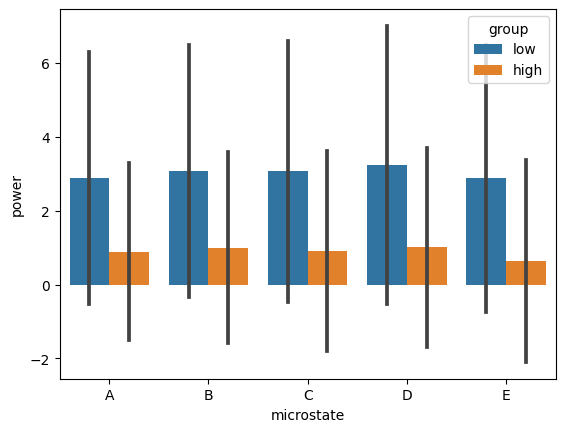


ANOVA SUMMARY

Source            SS    DF1    DF2       MS       F    p-unc    np2      eps
-----------  -------  -----  -----  -------  ------  -------  -----  -------
group        233.048      1     39  233.048  10.616    0.002  0.214  nan
microstate     3.320      4    156    0.830   0.396    0.812  0.010    0.893
Interaction    0.448      4    156    0.112   0.053    0.995  0.001  nan



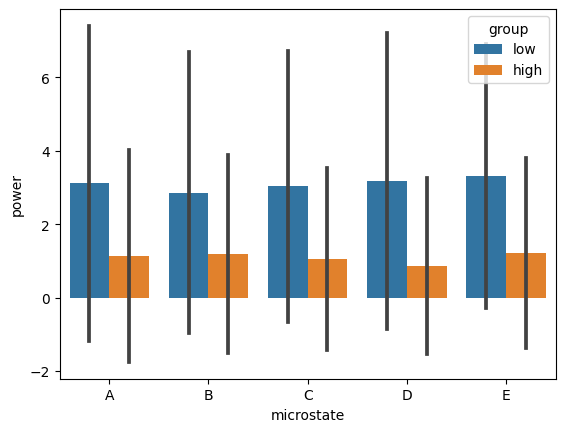


ANOVA SUMMARY

Source            SS    DF1    DF2       MS      F    p-unc    np2      eps
-----------  -------  -----  -----  -------  -----  -------  -----  -------
group        206.607      1     39  206.607  7.907    0.008  0.169  nan
microstate     1.844      4    156    0.461  0.212    0.931  0.005    0.862
Interaction    2.174      4    156    0.544  0.250    0.909  0.006  nan



In [6]:
# By target and accuracy
grouped_power_f0 = power_f0[power_f0.stim == 130]
grouped_power_f0 = grouped_power_f0.groupby(['subject', 'stim', 'target', 'microstate', 'group'], as_index=False)['power'].mean()
sns.barplot(grouped_power_f0, x="microstate", y="power", hue="group", errorbar = 'sd')
plt.show()
aov = grouped_power_f0.mixed_anova(dv='power', within='microstate', between='group', subject='subject')
pg.print_table(aov)

grouped_power_f0 = power_f0[power_f0.stim == 200]
grouped_power_f0 = grouped_power_f0.groupby(['subject', 'stim', 'target', 'microstate', 'group'], as_index=False)['power'].mean()
sns.barplot(grouped_power_f0, x="microstate", y="power", hue="group", errorbar = 'sd')
plt.show()
aov = grouped_power_f0.mixed_anova(dv='power', within='microstate', between='group', subject='subject')
pg.print_table(aov)

grouped_power_f0 = power_f0[power_f0.stim == 280]
grouped_power_f0 = grouped_power_f0.groupby(['subject', 'stim', 'target', 'microstate', 'group'], as_index=False)['power'].mean()
sns.barplot(grouped_power_f0, x="microstate", y="power", hue="group", errorbar = 'sd')
plt.show()
aov = grouped_power_f0.mixed_anova(dv='power', within='microstate', between='group', subject='subject')
pg.print_table(aov)

### MLM

#### Low accuracy

In [7]:
## format data for multilevel model
power_f0_low = power_f0[power_f0.group == "low"]

sub = LabelEncoder().fit_transform(power_f0_low.subject)

le_stim = LabelEncoder() # we'll hold onto this encoder for later
freq = le_stim.fit_transform(power_f0_low.stim)

scaler = StandardScaler() # we can set priors on unit scale
power = scaler.fit_transform(power_f0_low.power.to_numpy()[:, np.newaxis])[:, 0]

le_ms = LabelEncoder() 
microstate = le_ms.fit_transform(power_f0_low.microstate)

In [8]:
## fit Bayesian multilevel model
with pm.Model() as model:
    # each microstate has some mean power at F0
    mu = pm.Normal('means', 0, 1, size = np.unique(microstate).size)
    # there may be tone-by-tone variation though, and we randomly sampled tones
    # from the "population" of possible tones, so that's a random effect
    z_tone = pm.Normal('z_tone', 0, 1, size = np.unique(freq).size)
    sigma_tone = pm.Exponential('sigma_tone', 1)
    tone_effect = z_tone*sigma_tone
    # and also a random effect for the subject
    z_sub = pm.Normal('z_sub', 0, 1, size = np.unique(sub).size)
    sigma_sub = pm.Exponential('sigma_sub', 1)
    sub_effect = z_sub*sigma_sub
    # put it all together
    yhat = mu[microstate] + tone_effect[freq] + sub_effect[sub]
    sigma = pm.Exponential('sigma', 1) # noise prior
    pm.Normal('likelihood', yhat, sigma, observed = power)

    trace = pm.sample(
        chains = 4, 
        cores = 4, 
        draws = 2500, # per chain
        target_accept = .95, 
        random_seed = 0
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [means, z_tone, sigma_tone, z_sub, sigma_sub, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 193 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.


In [9]:
## extract posterior sample for quantities of interest
trc = trace.posterior.stack(draws = ("chain", "draw")) # get samples
mu = scaler.inverse_transform(trc['means'].values) # convert back to dB
delta = np.stack([mu - mu[i, :] for i in range(mu.shape[0])], axis = 0) 
print('mu: (microstates, samples) = (%d, %d)'%mu.shape)
print('delta: (microstates, microstates, samples) = (%d, %d, %d)'%delta.shape)

mu: (microstates, samples) = (5, 10000)
delta: (microstates, microstates, samples) = (5, 5, 10000)


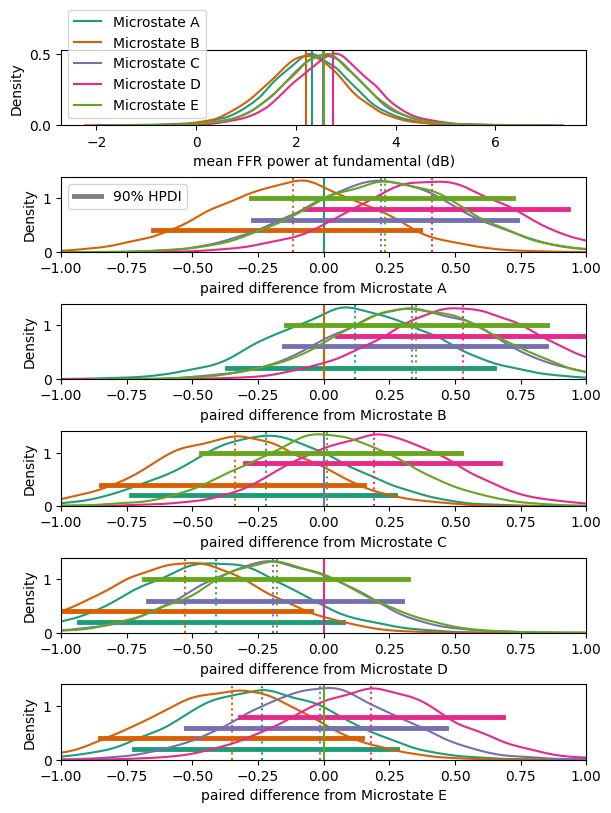

In [15]:
## plot posterior distribtuions for each microstate and their differences
fig, axs = plt.subplots(6, 1, figsize = (6, 8), constrained_layout=True)
colors = plt.colormaps['Dark2'].colors[:5]

# plot posterior means
for i in range(mu.shape[0]):
    ms = le_ms.inverse_transform([i])[0]
    sns.kdeplot(mu[i, :], color = colors[i], ax = axs[0])
    axs[0].axvline(mu[i, :].mean(), color = colors[i], label = 'Microstate %s'%ms)
axs[0].legend()
# axs[0].set_xlim(-1, 4)
axs[0].set_xlabel('mean FFR power at fundamental (dB)')
xmin, xmax = axs[0].get_xlim()

# plot posteriors of differences in mean
for i in range(delta.shape[0]):
    # print(i)
    ms = le_ms.inverse_transform([i])[0]
    ax = axs[i + 1]
    ax.set_xlim([-1, 1])
    ax.set_xlabel('paired difference from Microstate %s'%ms)
    # ax.set_yticks([0, .5, 1.])
    ms = le_ms.inverse_transform([i])[0]
    for j in range(delta.shape[1]):
        if i != j:
            ax.axvline(delta[i, j].mean(), color = colors[j], linestyle = 'dotted')
            sns.kdeplot(delta[i, j], color = colors[j], ax = ax)
            hdi_prob = .9
            hdi = az.hdi(delta[i, j], hdi_prob = hdi_prob)
            ax.plot([hdi[0], hdi[1]], [.2*(j+1), .2*(j+1)], color = colors[j], linewidth = 3.5)
        else:
            ax.axvline(delta[i, j].mean(), color = colors[j])
    if i == 0:
        ax.plot([], [], color = 'grey', linewidth = 3.5, label = '%d%% HPDI'%(hdi_prob*100))
        ax.legend()

# plt.savefig('../figs/posteriors.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()


In [11]:
def print_hpdi(hdi_prob):
    for i in range(delta.shape[0]):
        ms = le_ms.inverse_transform([i])[0]
        print('\nDifference from Microstate %s, %d%% HPDI:'%(ms, 100*hdi_prob))
        for j in range(delta.shape[1]):
            if i == j:
                continue
            _ms = le_ms.inverse_transform([j])[0]
            hdi = az.hdi(delta[i, j], hdi_prob = hdi_prob)
            star = '\t\t(*)' if np.sign(hdi[0]) == np.sign(hdi[1]) else ''
            print('%s: %.03f, [%.03f, %.03f]'%(_ms,delta[i, j].mean(),hdi[0],hdi[1])+star)

print_hpdi(.9)
print('\n-------------------------------------------------')
print_hpdi(.95)


Difference from Microstate A, 90% HPDI:
B: -0.118, [-0.650, 0.367]
C: 0.220, [-0.270, 0.736]
D: 0.412, [-0.073, 0.930]
E: 0.233, [-0.278, 0.722]

Difference from Microstate B, 90% HPDI:
A: 0.118, [-0.367, 0.650]
C: 0.338, [-0.152, 0.848]
D: 0.530, [0.050, 1.064]		(*)
E: 0.351, [-0.144, 0.851]

Difference from Microstate C, 90% HPDI:
A: -0.220, [-0.736, 0.270]
B: -0.338, [-0.848, 0.152]
D: 0.192, [-0.299, 0.670]
E: 0.014, [-0.466, 0.524]

Difference from Microstate D, 90% HPDI:
A: -0.412, [-0.930, 0.073]
B: -0.530, [-1.064, -0.050]		(*)
C: -0.192, [-0.670, 0.299]
E: -0.179, [-0.683, 0.320]

Difference from Microstate E, 90% HPDI:
A: -0.233, [-0.722, 0.278]
B: -0.351, [-0.851, 0.144]
C: -0.014, [-0.524, 0.466]
D: 0.179, [-0.320, 0.683]

-------------------------------------------------

Difference from Microstate A, 95% HPDI:
B: -0.118, [-0.764, 0.467]
C: 0.220, [-0.363, 0.821]
D: 0.412, [-0.193, 1.015]
E: 0.233, [-0.361, 0.848]

Difference from Microstate B, 95% HPDI:
A: 0.118, [-0.467

#### High accuracy

In [16]:
## format data for multilevel model
power_f0_high = power_f0[power_f0.group == "high"]

sub = LabelEncoder().fit_transform(power_f0_high.subject)

le_tone = LabelEncoder() # we'll hold onto this encoder for later
tone = le_tone.fit_transform(power_f0_high.stim)

scaler = StandardScaler() # we can set priors on unit scale
power = scaler.fit_transform(power_f0_high.power.to_numpy()[:, np.newaxis])[:, 0]

le_ms = LabelEncoder() 
microstate = le_ms.fit_transform(power_f0_high.microstate)

In [20]:
## fit Bayesian multilevel model
with pm.Model() as model:
    # each microstate has some mean power at F0
    mu = pm.Normal('means', 0, 1, size = np.unique(microstate).size)
    # there may be tone-by-tone variation though, and we randomly sampled tones
    # from the "population" of possible tones, so that's a random effect
    z_tone = pm.Normal('z_tone', 0, 1, size = np.unique(freq).size)
    sigma_tone = pm.Exponential('sigma_tone', 1)
    tone_effect = z_tone*sigma_tone
    # and also a random effect for the subject
    z_sub = pm.Normal('z_sub', 0, 1, size = np.unique(sub).size)
    sigma_sub = pm.Exponential('sigma_sub', 1)
    sub_effect = z_sub*sigma_sub
    # put it all together
    yhat = mu[microstate] + tone_effect[tone] + sub_effect[sub]
    sigma = pm.Exponential('sigma', 1) # noise prior
    pm.Normal('likelihood', yhat, sigma, observed = power)

    trace = pm.sample(
        chains = 4, 
        cores = 4, 
        draws = 2500, # per chain
        target_accept = .95, 
        random_seed = 0
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [means, z_tone, sigma_tone, z_sub, sigma_sub, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 150 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot: title={'center': 'means'}>,
        <AxesSubplot: title={'center': 'means'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>],
       [<AxesSubplot: title={'center': 'sigma_sub'}>,
        <AxesSubplot: title={'center': 'sigma_sub'}>],
       [<AxesSubplot: title={'center': 'sigma_tone'}>,
        <AxesSubplot: title={'center': 'sigma_tone'}>],
       [<AxesSubplot: title={'center': 'z_sub'}>,
        <AxesSubplot: title={'center': 'z_sub'}>],
       [<AxesSubplot: title={'center': 'z_tone'}>,
        <AxesSubplot: title={'center': 'z_tone'}>]], dtype=object)

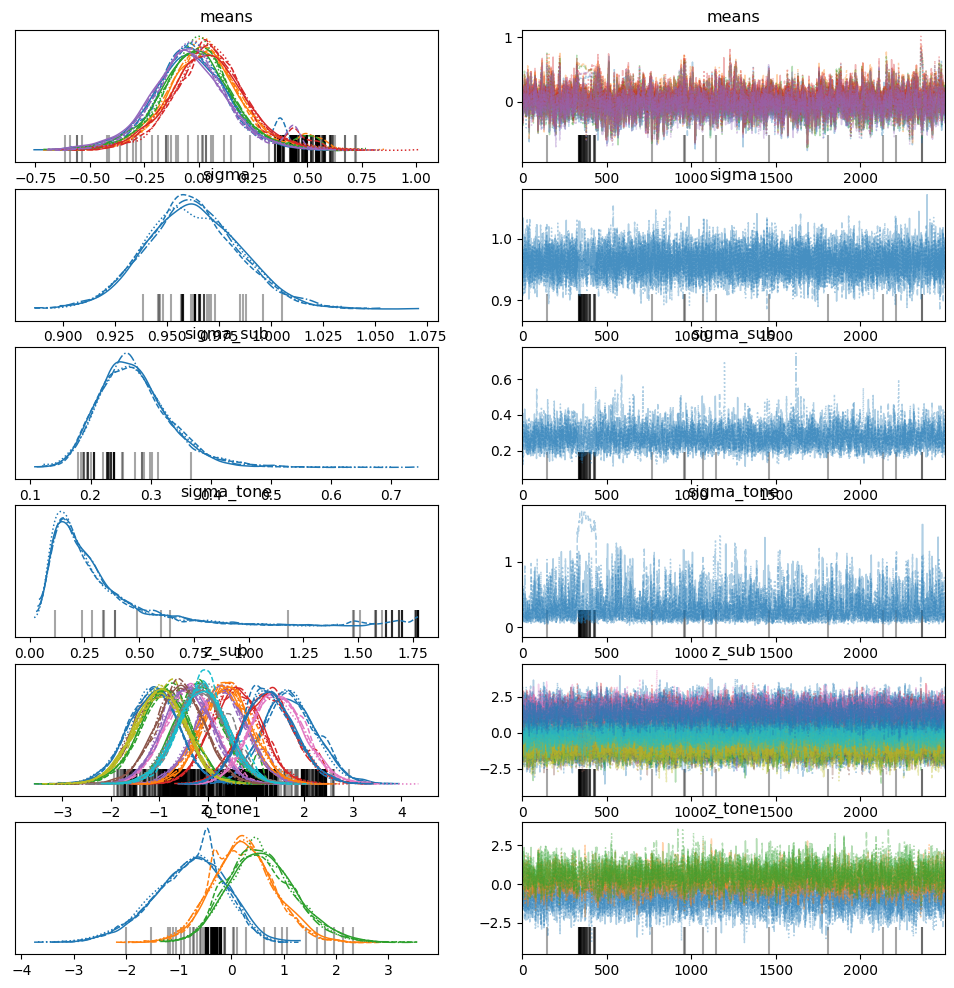

In [32]:
az.plot_trace(trace)

<AxesSubplot: >

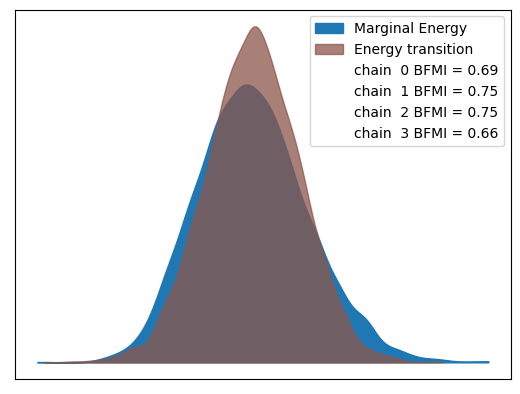

In [31]:
az.plot_forest(trace, var_names = )

In [34]:
az.summary(trace, round_to = 2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],-0.03,0.18,-0.33,0.38,0.01,0.00,1066.54,325.33,1.0
means[1],0.03,0.18,-0.33,0.39,0.01,0.01,888.10,332.71,1.0
means[2],-0.00,0.18,-0.38,0.35,0.01,0.01,894.03,322.15,1.0
means[3],0.05,0.18,-0.28,0.43,0.01,0.01,997.67,320.74,1.0
means[4],-0.04,0.18,-0.39,0.34,0.01,0.00,944.46,309.76,1.0
sigma,0.96,0.02,0.92,1.00,0.00,0.00,10446.20,7487.76,1.0
sigma_sub,0.27,0.06,0.17,0.39,0.00,0.00,2230.49,3933.37,1.0
sigma_tone,0.30,0.24,0.04,0.69,0.02,0.01,865.94,394.57,1.0
z_sub[0],1.70,0.55,0.65,2.70,0.01,0.01,3596.75,6932.38,1.0
z_sub[1],0.31,0.51,-0.69,1.25,0.01,0.00,7097.26,7265.04,1.0


In [29]:
trc

<xarray.Dataset> Size: 3MB
Dimensions:       (means_dim_0: 5, draws: 10000, z_sub_dim_0: 21,
                   z_tone_dim_0: 3)
Coordinates:
  * means_dim_0   (means_dim_0) int64 40B 0 1 2 3 4
  * z_sub_dim_0   (z_sub_dim_0) int64 168B 0 1 2 3 4 5 6 ... 15 16 17 18 19 20
  * z_tone_dim_0  (z_tone_dim_0) int64 24B 0 1 2
  * draws         (draws) object 80kB MultiIndex
  * chain         (draws) int64 80kB 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  * draw          (draws) int64 80kB 0 1 2 3 4 5 ... 2495 2496 2497 2498 2499
Data variables:
    means         (means_dim_0, draws) float64 400kB 0.5737 0.3476 ... 0.06958
    sigma         (draws) float64 80kB 1.013 0.9605 0.9171 ... 1.001 0.9897
    sigma_sub     (draws) float64 80kB 0.2579 0.199 0.2257 ... 0.1884 0.1768
    sigma_tone    (draws) float64 80kB 0.5008 0.7829 0.3192 ... 0.1545 0.442
    z_sub         (z_sub_dim_0, draws) float64 2MB 0.6703 2.704 ... 0.1912
    z_tone        (z_tone_dim_0, draws) float64 240kB -1.044 -0.7697 ... 0.2943
Attributes:
    created_at:                 2024-08-26T17:00:16.839954+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              149.82759928703308
    tuning_steps:               1000

In [21]:
## extract posterior sample for quantities of interest
trc = trace.posterior.stack(draws = ("chain", "draw")) # get samples
mu = scaler.inverse_transform(trc['means'].values) # convert back to dB
delta = np.stack([mu - mu[i, :] for i in range(mu.shape[0])], axis = 0) 
print('mu: (microstates, samples) = (%d, %d)'%mu.shape)
print('delta: (microstates, microstates, samples) = (%d, %d, %d)'%delta.shape)

mu: (microstates, samples) = (5, 10000)
delta: (microstates, microstates, samples) = (5, 5, 10000)


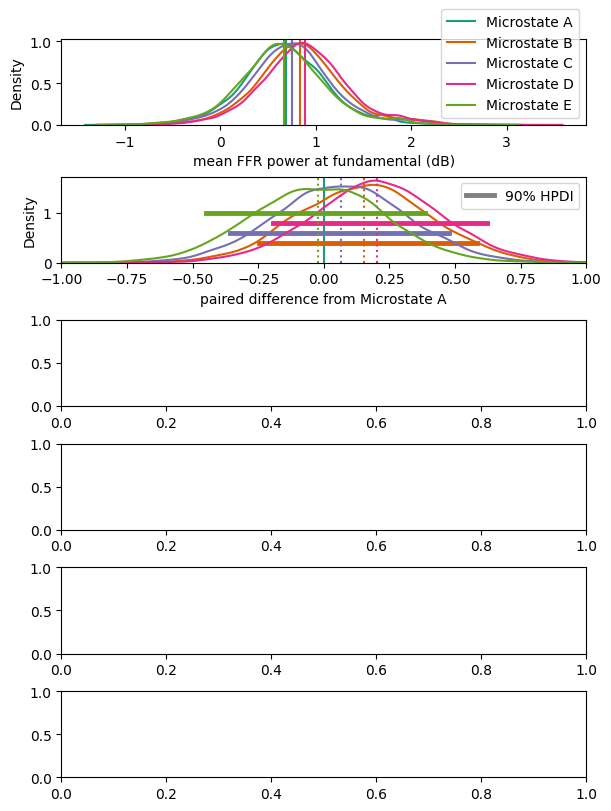

In [26]:
## plot posterior distribtuions for each microstate and their differences
fig, axs = plt.subplots(6, 1, figsize = (6, 8), constrained_layout=True)
colors = plt.colormaps['Dark2'].colors[:5]

# plot posterior means
for i in range(mu.shape[0]):
    ms = le_ms.inverse_transform([i])[0]
    sns.kdeplot(mu[i, :], color = colors[i], ax = axs[0])
    axs[0].axvline(mu[i, :].mean(), color = colors[i], label = 'Microstate %s'%ms)
axs[0].legend()
# axs[0].set_xlim(-1, 4)
axs[0].set_xlabel('mean FFR power at fundamental (dB)')
xmin, xmax = axs[0].get_xlim()

# plot posteriors of differences in mean
for i in range(delta.shape[0]):
    ms = le_ms.inverse_transform([i])[0]
    ax = axs[i + 1]
    ax.set_xlim([-1, 1])
    ax.set_xlabel('paired difference from Microstate %s'%ms)
    # ax.set_yticks([0, .5, 1.])
    ms = le_ms.inverse_transform([i])[0]
    for j in range(delta.shape[1]):
        if i != j:
            ax.axvline(delta[i, j].mean(), color = colors[j], linestyle = 'dotted')
            sns.kdeplot(delta[i, j], color = colors[j], ax = ax)
            hdi_prob = .9
            hdi = az.hdi(delta[i, j], hdi_prob = hdi_prob)
            ax.plot([hdi[0], hdi[1]], [.2*(j+1), .2*(j+1)], color = colors[j], linewidth = 3.5)
        else:
            ax.axvline(delta[i, j].mean(), color = colors[j])
    if i == 0:
        ax.plot([], [], color = 'grey', linewidth = 3.5, label = '%d%% HPDI'%(hdi_prob*100))
        ax.legend()
        break
    break

# plt.savefig('../figs/posteriors.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()


## Interactions

#### Try fitting one bigger model

In [35]:
# power_f0['accuracy'] = power_f0.accuracy_group
# power_f0 = power_f0.drop(columns = ['accuracy_group'])
power_f0

,subject,target,stim,microstate,frequency,power,trials,Unnamed: 0,accuracy,group
0,3,130,130,A,129.460581,-0.366394,84,2,0.785415,low
1,3,200,130,A,129.460581,5.104164,111,2,0.785415,low
2,3,280,130,A,129.460581,2.302977,96,2,0.785415,low
3,3,130,130,B,129.460581,1.635729,95,2,0.785415,low
4,3,200,130,B,129.460581,1.120924,142,2,0.785415,low
...,...,...,...,...,...,...,...,...,...,...
1840,45,200,280,D,278.838174,0.194377,96,44,0.972829,high
1841,45,280,280,D,278.838174,2.346454,125,44,0.972829,high
1842,45,130,280,E,278.838174,-3.038763,96,44,0.972829,high
1843,45,200,280,E,278.838174,-1.076164,82,44,0.972829,high


In [39]:
## format data for multilevel model
sub = LabelEncoder().fit_transform(power_f0.subject)

le_tone = LabelEncoder() # we'll hold onto this encoder for later
tone = le_stim.fit_transform(power_f0.stim)

scaler = StandardScaler() # we can set priors on unit scale
power = scaler.fit_transform(power_f0.power.to_numpy()[:, np.newaxis])[:, 0]

le_ms = LabelEncoder() 
microstate = le_ms.fit_transform(power_f0.microstate)

le_target = LabelEncoder() 
target = le_target.fit_transform(power_f0.target)

le_accuracy = LabelEncoder() 
accuracy = le_accuracy.fit_transform(power_f0.accuracy)

In [40]:
## fit Bayesian multilevel model
with pm.Model() as model:
    # each microstate has some mean power at F0
    mu = pm.Normal('means', 0, 1, size = np.unique(microstate).size)
    # there may be tone-by-tone variation though, and we randomly sampled tones
    # from the "population" of possible tones, so that's a random effect
    z_tone = pm.Normal('z_tone', 0, 1, size = np.unique(freq).size)
    sigma_tone = pm.Exponential('sigma_tone', 1)
    tone_effect = z_tone*sigma_tone
    # and also a random effect for the subject
    z_sub = pm.Normal('z_sub', 0, 1, size = np.unique(sub).size)
    sigma_sub = pm.Exponential('sigma_sub', 1)
    sub_effect = z_sub*sigma_sub
    # random effect for target
    z_target = pm.Normal('z_target', 0, 1, size = np.unique(sub).size)
    sigma_target = pm.Exponential('sigma_target', 1)
    target_effect = z_target*sigma_target
    # random effect for accuracy
    z_accuracy = pm.Normal('z_accuracy', 0, 1, size = np.unique(sub).size)
    sigma_accuracy = pm.Exponential('sigma_accuracy', 1)
    accuracy_effect = z_accuracy*sigma_accuracy
    # put it all together
    yhat = mu[microstate] + tone_effect[tone] + sub_effect[sub] + target_effect[target] + accuracy_effect[accuracy]
    sigma = pm.Exponential('sigma', 1) # noise prior
    pm.Normal('likelihood', yhat, sigma, observed = power)

    trace = pm.sample(
        chains = 4, 
        cores = 4, 
        draws = 2500, # per chain
        target_accept = .95, 
        random_seed = 0
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [means, z_tone, sigma_tone, z_sub, sigma_sub, z_target, sigma_target, z_accuracy, sigma_accuracy, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 790 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


In [78]:
az.summary(trace, round_to = 2, var_names = ['sigma*'], filter_vars = 'regex')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.83,0.01,0.81,0.86,0.00,0.00,21311.73,7080.65,1.0
sigma_accuracy,0.34,0.19,0.00,0.59,0.01,0.01,481.99,1699.64,1.0
sigma_sub,0.36,0.18,0.01,0.61,0.01,0.01,514.06,1478.25,1.0
sigma_target,0.12,0.15,0.00,0.35,0.00,0.00,2565.66,3942.30,1.0
sigma_tone,0.37,0.28,0.08,0.84,0.01,0.00,3491.12,4470.10,1.0


In [76]:
trace.posterior['sigma_accuracy']

<xarray.DataArray 'sigma_accuracy' (chain: 4, draw: 2500)> Size: 80kB
array([[0.24952445, 0.4156038 , 0.27560313, ..., 0.52633324, 0.50372823,
        0.5131611 ],
       [0.56386082, 0.49871992, 0.42461141, ..., 0.5266861 , 0.41440906,
        0.54975141],
       [0.14048296, 0.08065589, 0.20276525, ..., 0.19900544, 0.12411121,
        0.0880659 ],
       [0.22161946, 0.0793533 , 0.20177339, ..., 0.26480898, 0.38716945,
        0.38400496]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 20kB 0 1 2 3 4 5 6 ... 2494 2495 2496 2497 2498 2499

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

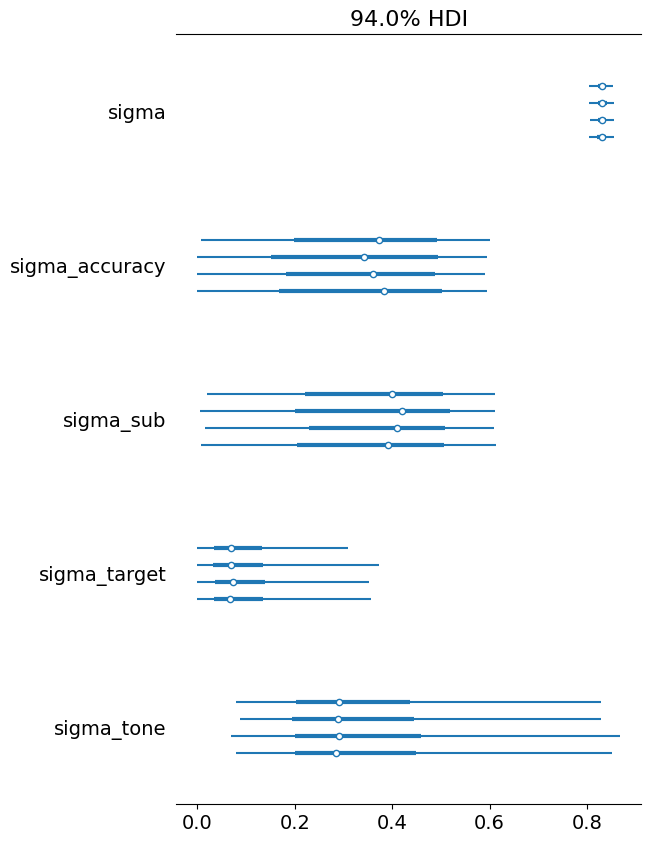

In [83]:
az.plot_forest(trace, var_names = ['sigma*'], filter_vars = 'regex')

In [41]:
## extract posterior sample for quantities of interest
trc = trace.posterior.stack(draws = ("chain", "draw")) # get samples
mu = scaler.inverse_transform(trc['means'].values) # convert back to dB
delta = np.stack([mu - mu[i, :] for i in range(mu.shape[0])], axis = 0) 
print('mu: (microstates, samples) = (%d, %d)'%mu.shape)
print('delta: (microstates, microstates, samples) = (%d, %d, %d)'%delta.shape)

mu: (microstates, samples) = (5, 10000)
delta: (microstates, microstates, samples) = (5, 5, 10000)


In [71]:
np.shape(trc['sigma_tone'].values)

()

In [65]:
np.shape(trc['means'].values)

(5, 10000)

In [64]:
np.shape(mu)

(5, 10000)

In [42]:
trc

<xarray.Dataset> Size: 11MB
Dimensions:           (means_dim_0: 5, draws: 10000, z_accuracy_dim_0: 41,
                       z_sub_dim_0: 41, z_target_dim_0: 41, z_tone_dim_0: 3)
Coordinates:
  * means_dim_0       (means_dim_0) int64 40B 0 1 2 3 4
  * z_accuracy_dim_0  (z_accuracy_dim_0) int64 328B 0 1 2 3 4 ... 36 37 38 39 40
  * z_sub_dim_0       (z_sub_dim_0) int64 328B 0 1 2 3 4 5 ... 35 36 37 38 39 40
  * z_target_dim_0    (z_target_dim_0) int64 328B 0 1 2 3 4 5 ... 36 37 38 39 40
  * z_tone_dim_0      (z_tone_dim_0) int64 24B 0 1 2
  * draws             (draws) object 80kB MultiIndex
  * chain             (draws) int64 80kB 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3
  * draw              (draws) int64 80kB 0 1 2 3 4 ... 2495 2496 2497 2498 2499
Data variables:
    means             (means_dim_0, draws) float64 400kB -0.1709 ... 0.03871
    sigma             (draws) float64 80kB 0.8318 0.8148 ... 0.8337 0.8202
    sigma_accuracy    (draws) float64 80kB 0.2495 0.4156 0.2756 ... 0.3872 0.384
    sigma_sub         (draws) float64 80kB 0.4237 0.3217 ... 0.3791 0.5864
    sigma_target      (draws) float64 80kB 0.04515 0.003657 ... 0.04907 0.09571
    sigma_tone        (draws) float64 80kB 0.7621 0.1937 ... 0.1782 0.4542
    z_accuracy        (z_accuracy_dim_0, draws) float64 3MB -0.5321 ... -0.9823
    z_sub             (z_sub_dim_0, draws) float64 3MB 1.115 0.5685 ... 0.3925
    z_target          (z_target_dim_0, draws) float64 3MB -0.8118 ... 3.524
    z_tone            (z_tone_dim_0, draws) float64 240kB -0.06434 ... 0.0022
Attributes:
    created_at:                 2024-08-26T17:44:13.441748+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              790.4898281097412
    tuning_steps:               1000

array([[<AxesSubplot: title={'center': 'means'}>,
        <AxesSubplot: title={'center': 'means'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>],
       [<AxesSubplot: title={'center': 'sigma_accuracy'}>,
        <AxesSubplot: title={'center': 'sigma_accuracy'}>],
       [<AxesSubplot: title={'center': 'sigma_sub'}>,
        <AxesSubplot: title={'center': 'sigma_sub'}>],
       [<AxesSubplot: title={'center': 'sigma_target'}>,
        <AxesSubplot: title={'center': 'sigma_target'}>],
       [<AxesSubplot: title={'center': 'sigma_tone'}>,
        <AxesSubplot: title={'center': 'sigma_tone'}>],
       [<AxesSubplot: title={'center': 'z_accuracy'}>,
        <AxesSubplot: title={'center': 'z_accuracy'}>],
       [<AxesSubplot: title={'center': 'z_sub'}>,
        <AxesSubplot: title={'center': 'z_sub'}>],
       [<AxesSubplot: title={'center': 'z_target'}>,
        <AxesSubplot: title={'center': 'z_target'}>],
       [<AxesSubplot: tit

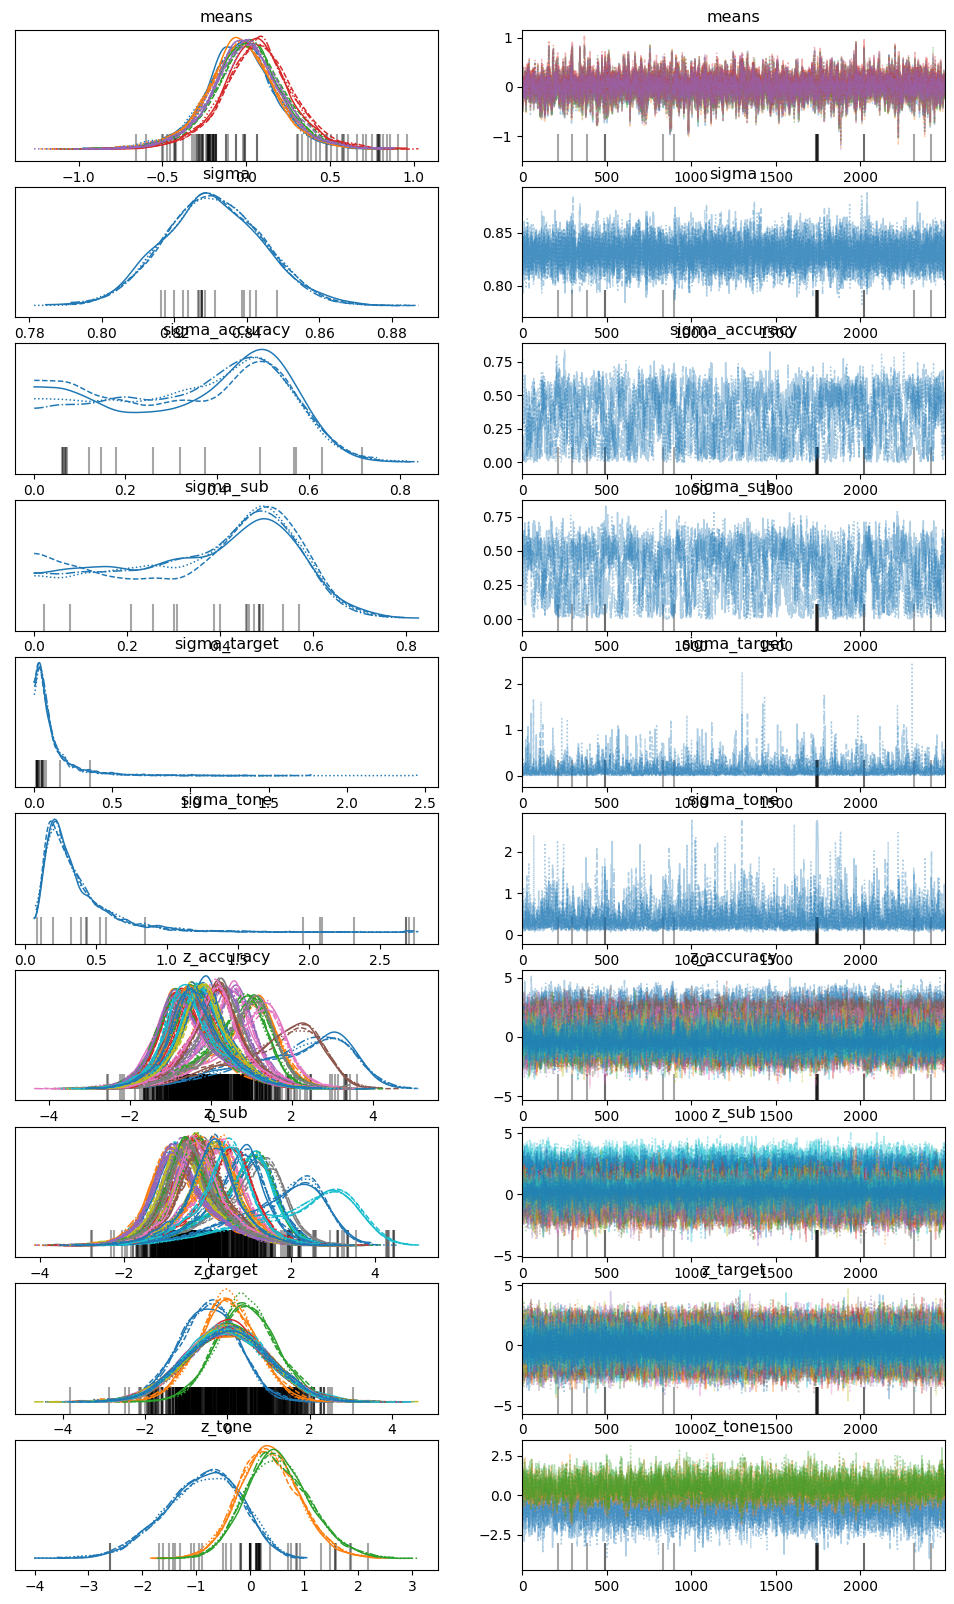

In [46]:
az.plot_trace(trace)

In [48]:
az.summary(trace, round_to = 2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],-0.03,0.22,-0.48,0.38,0.00,0.00,2136.29,2437.34,1.0
means[1],-0.03,0.22,-0.46,0.39,0.00,0.00,2184.94,2508.50,1.0
means[2],0.01,0.22,-0.44,0.42,0.00,0.00,2127.40,2650.14,1.0
means[3],0.06,0.22,-0.38,0.48,0.00,0.00,2185.50,2600.39,1.0
means[4],-0.00,0.22,-0.44,0.41,0.00,0.00,2153.55,2559.82,1.0
...,...,...,...,...,...,...,...,...,...
z_target[39],-0.00,1.00,-1.83,1.90,0.01,0.01,20904.64,6904.18,1.0
z_target[40],-0.00,1.00,-1.81,1.89,0.01,0.01,18338.24,6956.86,1.0
z_tone[0],-0.90,0.71,-2.17,0.40,0.01,0.01,3458.83,3159.44,1.0
z_tone[1],0.36,0.57,-0.69,1.46,0.01,0.01,3291.29,5003.64,1.0


array([<AxesSubplot: title={'center': '95.0% HDI'}>], dtype=object)

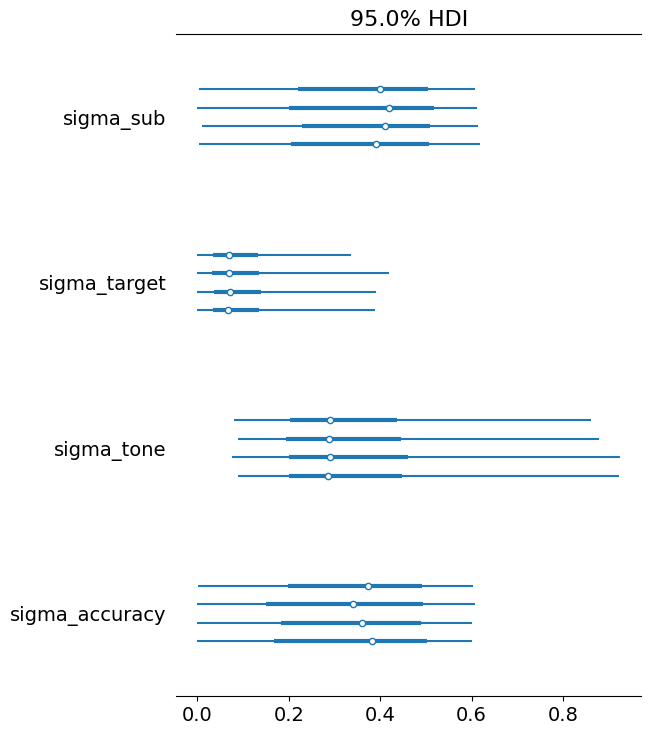

In [72]:
az.plot_forest(trace, var_names = ['sigma_sub', 'sigma_target', 'sigma_tone', 'sigma_accuracy'], hdi_prob = 0.95)

In [73]:
le_ms.inverse_transform([1])[0]

'B'

In [75]:
np.shape(mu)

(5, 10000)

/project/hcn1/.conda/envs/mne/lib/python3.11/site-packages/matplotlib/lines.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if style in ['solid', 'None']:
/project/hcn1/.conda/envs/mne/lib/python3.11/site-packages/matplotlib/lines.py:43: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif style in ['dashed', 'dashdot', 'dotted']:


ValueError: Unrecognized linestyle: array([ 1,  1,  1, ..., 33, 33, 33])

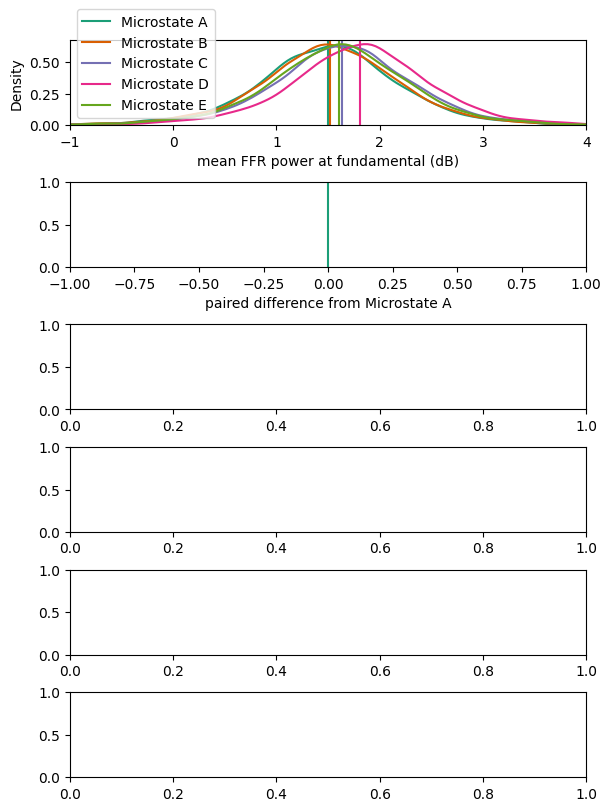

In [60]:
## extract posterior sample for quantities of interest
trc = trace.posterior.stack(draws = ("chain", "draw")) # get samples
mu = scaler.inverse_transform(trc['means'].values) # convert back to dB
delta = np.stack([mu - mu[i, :] for i in range(mu.shape[0])], axis = 0) # differences between each microstate
print('mu: (microstates, samples) = (%d, %d)'%mu.shape)
print('delta: (microstates, microstates, samples) = (%d, %d, %d)'%delta.shape)

## plot posterior distribtuions for each microstate and their differences
fig, axs = plt.subplots(6, 1, figsize = (6, 8), constrained_layout=True)
colors = plt.colormaps['Dark2'].colors[:5]

# plot posterior means
for i in range(mu.shape[0]):
    ms = le_ms.inverse_transform([i])[0]
    sns.kdeplot(mu[i, :], color = colors[i], ax = axs[0])
    axs[0].axvline(mu[i, :].mean(), color = colors[i], label = 'Microstate %s'%ms)
axs[0].legend()
axs[0].set_xlim(-1, 4)
axs[0].set_xlabel('mean FFR power at fundamental (dB)')
xmin, xmax = axs[0].get_xlim()

# plot posteriors of differences in mean
for i in range(delta.shape[0]):
    ms = le_ms.inverse_transform([i])[0]
    ax = axs[i + 1]
    ax.set_xlim([-1, 1])
    ax.set_xlabel('paired difference from Microstate %s'%ms)
    # ax.set_yticks([0, .5, 1.])
    for j in range(delta.shape[1]):
        if i != j:
            ax.axvline(delta[i, j].mean(), color = colors[j], linestyle = 'dotted')
            sns.kdeplot(delta[i, j], color = colors[j], ax = ax)
            hdi_prob = .9
            hdi = az.hdi(delta[i, j], hdi_prob = hdi_prob)
            ax.plot([hdi[0], hdi[1]], [.2*(j+1), .2*(j+1)], color = colors[j], linewidth = 3.5)
        else:
            ax.axvline(delta[i, j].mean(), color = colors[j])
    if i == 0:
        ax.plot([], [], color = 'grey', linewidth = 3.5, label = '%d%% HPDI'%(hdi_prob*100))
        ax.legend()

# plt.savefig('../figs/posteriors.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()


### Factor in accuracies

In [3]:
# Read FFR peaks by microstate
power_f0 = pd.read_csv('microstates-power_f0.csv') # already has excluded subjects dropped, whoops, re-run this block of code to preserve them

# Read accuracies
accuracy = pd.read_csv('accuracies.csv')

# Add accuracy group to dataframe
accuracy = accuracy.rename(columns = {'sub_num': 'subject'})
power_f0 = power_f0.merge(accuracy, left_on = ["subject"], right_on = ["subject"])
# power_f0.to_csv('microstates-power_f0_accuracies.csv', index = False)
power_f0

,subject,predictable,target,tone,microstate,frequency,dB,trials,accuracy,accuracy_group
0,2,True,110,110,A,109.780439,0.754216,7,0.807447,low
1,2,True,150,110,A,109.780439,1.047382,24,0.807447,low
2,2,True,210,110,A,109.780439,-2.608353,28,0.807447,low
3,2,False,110,110,A,109.780439,4.728450,23,0.807447,low
4,2,False,150,110,A,109.780439,-1.890703,8,0.807447,low
...,...,...,...,...,...,...,...,...,...,...
2803,41,True,150,210,D,209.580838,3.145078,55,0.957115,high
2804,41,True,210,210,D,209.580838,1.608094,34,0.957115,high
2805,41,False,110,210,D,209.580838,5.156171,63,0.957115,high
2806,41,False,150,210,D,209.580838,0.134765,54,0.957115,high


<AxesSubplot: xlabel='dB', ylabel='Count'>

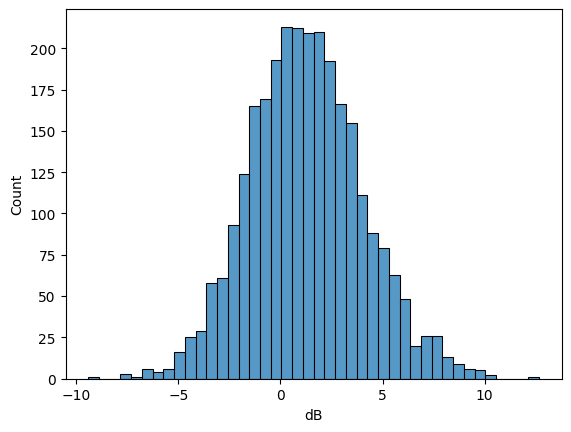

In [44]:
sns.histplot(power_f0.dB)

In [ ]:
import pytensor.tensor as at

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + at.dot(X.values, beta), sigma, observed=y.values)
